<a href="https://colab.research.google.com/github/DuckShyamalan/COMP6248-Reproducibility-Challenge/blob/main/Fine_Tuning_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import random
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

In [28]:
!wget https://artist-cloud.ecs.soton.ac.uk/s/sFkQ7HYOekDoDEG/download
!unzip download
!mv mnist MNIST
from torchvision.datasets import MNIST

--2021-05-09 18:30:16--  https://artist-cloud.ecs.soton.ac.uk/s/sFkQ7HYOekDoDEG/download
Resolving artist-cloud.ecs.soton.ac.uk (artist-cloud.ecs.soton.ac.uk)... 152.78.100.1, 2001:630:d0:f400::f001
Connecting to artist-cloud.ecs.soton.ac.uk (artist-cloud.ecs.soton.ac.uk)|152.78.100.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34602369 (33M) [application/zip]
Saving to: ‘download’

download            100%[===================>]  33.00M  14.6MB/s    in 2.3s    

2021-05-09 18:30:19 (14.6 MB/s) - ‘download’ saved [34602369/34602369]

Archive:  download
   creating: mnist/
  inflating: mnist/.DS_Store         
replace __MACOSX/mnist/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: __MACOSX/mnist/._.DS_Store  
   creating: mnist/processed/
   creating: mnist/raw/
  inflating: mnist/processed/training.pt  
  inflating: mnist/processed/test.pt  
  inflating: mnist/raw/t10k-images-idx3-ubyte  
  inflating: mnist/raw/t10k-labels-idx1-ubyte  
  

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])
trainset = MNIST("./", train=True, transform=transform)
testset = MNIST("./", train=False, transform=transform)
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]

In [30]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [31]:
class FineTuneModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(FineTuneModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) 
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, num_classes)  

  def forward(self, x):
    out = self.fc1(x)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.fc2(out)
    out = F.relu(out)
    out = self.fc3(out)
    if not self.training:
      out = F.softmax(out, dim=1)
    return out

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = FineTuneModel(784, 1200, 10)

loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)

trial.with_generators(trainloader, test_generator=testloader)

trial.run(epochs=2)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)

In [9]:
torch.save(model.state_dict(), "fine_tune.pt")

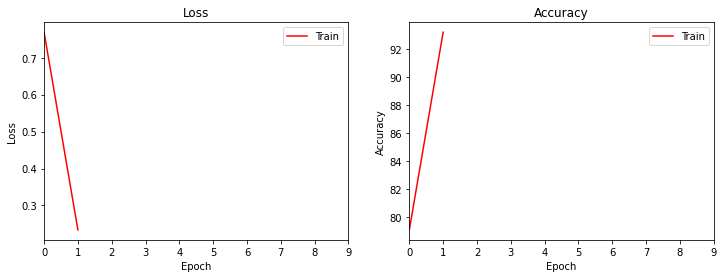

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
#fig.suptitle('', fontsize=16)
ax[0].plot([0.7688, 0.2338], color="red", label="Train")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss")
ax[0].set_xlim(xmin=0.0, xmax=9)
ax[0].legend()
ax[1].plot([i*100 for i in [0.791, 0.9317]], color="red", label="Train")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy")
ax[1].set_xlim(xmin=0.0, xmax=9)
ax[1].legend()

# **Blurring Images**

In [10]:
blur_sigma = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


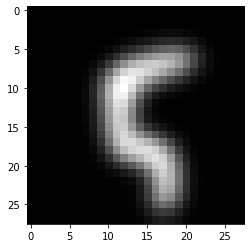

In [11]:
# Blurring training images
for i in range(0, len(trainset)):
  s = random.choice(blur_sigma)
  img = trainset.train_data[i].numpy()
  blurred_img = gaussian_filter(img, sigma=s)
  trainset.train_data[i] = torch.from_numpy(blurred_img)

plt.imshow(trainset.train_data[100], cmap=plt.get_cmap('gray'))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


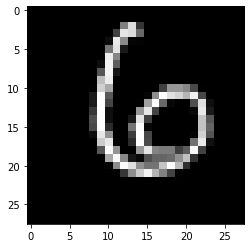

In [12]:
# Blurring test images
for i in range(0, len(testset)):
  s = random.choice(blur_sigma)
  img = testset.test_data[i].numpy()
  blurred_img = gaussian_filter(img, sigma=s)
  testset.test_data[i] = torch.from_numpy(blurred_img)

plt.imshow(testset.test_data[100], cmap=plt.get_cmap('gray'))

In [13]:
# Load blurred image data
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = FineTuneModel(784, 1200, 10)
model.load_state_dict(torch.load("fine_tune.pt"))

loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)

trial.with_generators(trainloader, test_generator=testloader)

trial.run(epochs=2)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)

In [15]:
torch.save(model.state_dict(),"blur_model.pt")

# **Adding Gaussian Noise to Images**

In [21]:
noise_variance = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


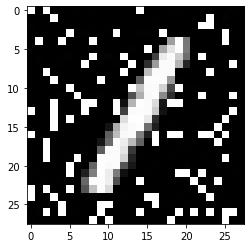

In [22]:
# Adding noise to training images
for i in range(0, len(trainset)):
  v = random.choice(noise_variance)
  img = trainset.train_data[i].numpy()
  noise = np.random.normal(0, np.sqrt(v), img.shape)
  noisy_img = img + noise
  trainset.train_data[i] = torch.from_numpy(noisy_img)

plt.imshow(trainset.train_data[205], cmap=plt.get_cmap('gray'))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


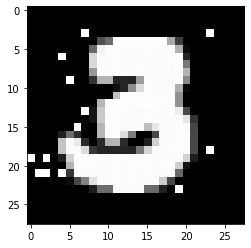

In [23]:
# Adding noise to test images
for i in range(0, len(testset)):
  v = random.choice(noise_variance)
  img = testset.test_data[i].numpy()
  noise = np.random.normal(0, np.sqrt(v), img.shape)
  noisy_img = img + noise
  testset.test_data[i] = torch.from_numpy(noisy_img)

plt.imshow(testset.test_data[200], cmap=plt.get_cmap('gray'))

In [24]:
# Load noisy image data
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [25]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = FineTuneModel(784, 1200, 10)
model.load_state_dict(torch.load("fine_tune.pt"))

loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)

trial.with_generators(trainloader, test_generator=testloader)

trial.run(epochs=2)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)

In [26]:
torch.save(model.state_dict(),"noise_model.pt")

In [27]:
import shutil
shutil.rmtree('MNIST', ignore_errors=True)